In [42]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import sys
import itertools
import datetime
import odc.algo
from copy import deepcopy
import warnings
from itertools import compress


sys.path.append('../Scripts')
from dea_plotting import rgb




   



    
dc = datacube.Datacube(app='Using_load_ard')


def load_ard(dc,
             products=None,
             min_gooddata=0.0,
             fmask_categories=['valid', 'snow', 'water'],
             mask_pixel_quality=True,
             mask_contiguity='nbart_contiguity',
             ls7_slc_off=True,
             filter_func=None,
             **dcload_kwargs):
    
    '''
    Loads Landsat Collection 3 or Sentinel 2 Definitive and Near Real 
    Time data for multiple sensors (i.e. ls5t, ls7e and ls8c for 
    Landsat; s2a and s2b for Sentinel 2), and returns a single masked 
    xarray dataset containing only observations that contain greater 
    than a given proportion of good quality pixels. This can be used 
    to extract clean time series of observations that are not affected 
    by cloud, for example as an input to the `animated_timeseries` 
    function from `dea_plotting`.
    
    The proportion of good quality pixels is calculated by summing the 
    pixels flagged as good quality in `fmask`. By default non-cloudy or 
    shadowed land, snow and water pixels are treated as good quality, 
    but this can be customised using the `fmask_gooddata` parameter.
    
    Last modified: February 2020
    
    Parameters
    ----------  
    dc : datacube Datacube object
        The Datacube to connect to, i.e. `dc = datacube.Datacube()`.
        This allows you to also use development datacubes if required.    
    products : list
        A list of product names to load data from. Valid options are 
        ['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'] for Landsat,
        ['s2a_ard_granule', 's2b_ard_granule'] for Sentinel 2 Definitive, 
        and ['s2a_nrt_granule', 's2b_nrt_granule'] for Sentinel 2 Near 
        Real Time (on the DEA Sandbox only).
    min_gooddata : float, optional
        An optional float giving the minimum percentage of good quality 
        pixels required for a satellite observation to be loaded. 
        Defaults to 0.0 which will return all observations regardless of
        pixel quality (set to e.g. 0.99 to return only observations with
        more than 99% good quality pixels).
    fmask_categories : list, optional
        An optional list of fmask category names to treat as good 
        quality observations in the above `min_gooddata` calculation. 
        The default is `['valid', 'snow', 'water']` which will return 
        non-cloudy or shadowed land, snow and water pixels. Choose from: 
        'nodata', 'valid', 'cloud', 'shadow', 'snow', and 'water'.
    mask_pixel_quality : bool, optional
        An optional boolean indicating whether to apply the good data 
        mask to all observations that were not filtered out for having 
        less good quality pixels than `min_gooddata`. E.g. if 
        `min_gooddata=0.99`, the filtered observations may still contain 
        up to 1% poor quality pixels. The default of False simply 
        returns the resulting observations without masking out these 
        pixels; True masks them and sets them to NaN using the good data 
        mask. This will convert numeric values to floating point values 
        which can cause memory issues, set to False to prevent this.
    mask_contiguity : str or bool, optional
        An optional string or boolean indicating whether to mask out 
        pixels missing data in any band (i.e. "non-contiguous" values). 
        Although most missing data issues are resolved by 
        `mask_invalid_data`, this step is important for generating 
        clean and concistent composite datasets. The default
        is `mask_contiguity='nbart_contiguity'` which will set any 
        pixels with non-contiguous values to NaN based on NBART data. 
        If you are loading NBAR data instead, you should specify
        `mask_contiguity='nbar_contiguity'` instead. To ignore non-
        contiguous values completely, set `mask_contiguity=False`.
        Be aware that masking out non-contiguous values will convert 
        all numeric values to floating point values when -999 values 
        are replaced with NaN, which can cause memory issues.
    mask_dtype : numpy dtype, optional
        An optional parameter that controls the data type/dtype that
        layers are coerced to when when `mask_pixel_quality=True` or 
        `mask_contiguity=True`. Defaults to `np.float32`, which uses
        approximately 1/2 the memory of `np.float64`.
    ls7_slc_off : bool, optional
        An optional boolean indicating whether to include data from 
        after the Landsat 7 SLC failure (i.e. SLC-off). Defaults to 
        True, which keeps all Landsat 7 observations > May 31 2003. 
    filter_func : function, optional
        An optional function that can be passed in to restrict the
        datasets that are loaded by the function. A filter function 
        should take a `datacube.model.Dataset` object as an input (i.e.
        as returned from `dc.find_datasets`), and return a boolean.
        For example, a filter function could be used to return True on
        only datasets acquired in January: 
        `dataset.time.begin.month == 1`
    **dcload_kwargs : 
        A set of keyword arguments to `dc.load` that define the 
        spatiotemporal query used to extract data. This typically
        includes `measurements`, `x`, `y`, `time`, `resolution`, 
        `resampling`, `group_by` and `crs`. Keyword arguments can 
        either be listed directly in the `load_ard` call like any 
        other parameter (e.g. `measurements=['nbart_red']`), or by 
        passing in a query kwarg dictionary (e.g. `**query`). For a 
        list of possible options, see the `dc.load` documentation: 
        https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html          
        
    Returns
    -------
    combined_ds : xarray Dataset
        An xarray dataset containing only satellite observations that 
        contains greater than `min_gooddata` proportion of good quality 
        pixels.   
        
    '''
    
    #########
    # Setup #
    #########

    # To prevent modifications to dcload_kwargs being made by this 
    # function remaining after the function is run (potentially causing 
    # different results each time the function is run), first take a 
    # deep copy of the dcload_kwargs object. 
    dcload_kwargs = deepcopy(dcload_kwargs)  

    # Determine if lazy loading is required
    lazy_load = 'dask_chunks' in dcload_kwargs

    # Warn user if they combine lazy load with min_gooddata
    if (min_gooddata > 0.0) & lazy_load:
                warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "
                              "will cause dask arrays to compute when "
                              "loading pixel-quality data to calculate "
                              "'good pixel' percentage. This can "
                              "significantly slow the return of your dataset.")

    # Verify that products were provided, and that only Sentinel-2 or 
    # only Landsat products are being loaded at the same time
    if not products:
        raise ValueError("Please provide a list of product names "
                         "to load data from. Valid options are: \n"
                         "['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'] " 
                         "for Landsat, ['s2a_ard_granule', "
                         "'s2b_ard_granule'] \nfor Sentinel 2 Definitive, or "
                         "['s2a_nrt_granule', 's2b_nrt_granule'] for "
                         "Sentinel 2 Near Real Time")
    elif all(['ls' in product for product in products]):
        product_type = 'ls'
    elif all(['s2' in product for product in products]):
        product_type = 's2'

    # If `measurements` are specified but do not include fmask or 
    # contiguity variables, add these to `measurements`
    to_drop = []  # store loaded var names here to later drop
    fmask_band = 'fmask'

    if 'measurements' in dcload_kwargs:        

        if fmask_band not in dcload_kwargs['measurements']:
            dcload_kwargs['measurements'].append(fmask_band)
            to_drop.append(fmask_band)

        if (mask_contiguity and 
            (mask_contiguity not in dcload_kwargs['measurements'])):
            dcload_kwargs['measurements'].append(mask_contiguity)
            to_drop.append(mask_contiguity)  

    # If no `measurements` are specified, Landsat ancillary bands are loaded
    # with a 'oa_' prefix, but Sentinel-2 bands are not. As a work-around, 
    # we need to rename the default contiguity and fmask bands if loading
    # Landsat data without specifying `measurements`
    elif product_type == 'ls': 
        mask_contiguity = f'oa_{mask_contiguity}' if mask_contiguity else False
        fmask_band = f'oa_{fmask_band}'     

    #################
    # Find datasets #
    #################

    # Extract datasets for each product using subset of dcload_kwargs
    dataset_list = []
    datasets_query = {k:v for k,v in dcload_kwargs.items() 
                      if k in ['time', 'x', 'y']}

    # Get list of datasets for each product
    print('Finding datasets')
    for product in products:    

        # Obtain list of datasets for product
        print(f'    {product}')
        datasets = dc.find_datasets(product=product, **datasets_query)    

        # Remove Landsat 7 SLC-off observations if ls7_slc_off=False
        if not ls7_slc_off and product == 'ga_ls7e_ard_3':
            print('    Ignoring SLC-off observations for ls7')
            datasets = [i for i in datasets if i.time.begin < 
                        datetime.datetime(2003, 5, 31)]

        # Add any returned datasets to list
        dataset_list.extend(datasets)
        
    # Raise exception if no datasets are returned
    if len(dataset_list) == 0:
        raise ValueError("No data available for query: ensure that "
                         "the products specified have data for the "
                         "time and location requested")        

    # If filter_func is specified, use this function to filter the list 
    # of datasets prior to load
    if filter_func:

        # Apply filter func to each dataset and filter list to True
        dataset_bool = [filter_func(i) for i in dataset_list]                       
        dataset_list = list(compress(dataset_list, dataset_bool))
        print(f'Filtering datasets using filter function')
        
    # Raise exception if filtering removes all datasets
    if len(dataset_list) == 0:
        raise ValueError("No data available after filtering with "
                         "filter function")   

    #############
    # Load data #
    #############     

    # If dask_chunks is specified, load data using dcload_kwargs only
    if lazy_load:
        ds = dc.load(datasets=dataset_list,
                     **dcload_kwargs)

    # If no dask chunks specified, add this param so that
    # we can lazy load data before filtering by good data
    else:
        ds = dc.load(datasets=dataset_list,
                     dask_chunks={},
                     **dcload_kwargs) 

    ###############
    # Apply masks #
    ###############
    
    # Calculate pixel quality mask
    pq_mask = odc.algo.fmask_to_bool(mask=ds[fmask_band], 
                                     categories=fmask_categories)
    
    # Generate good quality data mask
    mask = None
    if mask_pixel_quality:
        print('Applying pixel quality/cloud mask') 
        mask = pq_mask

    # Generate contiguity mask
    if mask_contiguity:  
        print('Applying contiguity mask')
        cont_mask = ds[mask_contiguity] == 1
        
        # If mask already has data if mask_pixel_quality == True, 
        # multiply with cont_mask to perform a logical 'or' operation 
        # (keeping only pixels good in both)
        mask = cont_mask if mask is None else mask * cont_mask

    # Mask data if either of the above masks were generated
    if mask is not None:
        ds = odc.algo.keep_good_only(ds, where=mask)    

    ####################
    # Filter good data #
    ####################

    # The good data percentage calculation has to load in all `fmask`
    # data, which can be slow. If the user has chosen no filtering 
    # by using the default `min_gooddata = 0`, we can skip this step 
    # completely to save processing time
    if min_gooddata > 0.0:

        # Compute good data for each observation as % of total pixels
        print('Counting good quality pixels for each time step')
        data_perc = (pq_mask.sum(axis=[1, 2], dtype='int32') / 
                     (pq_mask.shape[1] * pq_mask.shape[2]))

        # Filter by `min_gooddata` to drop low quality observations
        total_obs = len(ds.time)
        ds = ds.sel(time=data_perc >= min_gooddata)
        print(f'Filtering to {len(ds.time)} out of {total_obs} '
              f'time steps with at least {min_gooddata:.1%} '
              f'good quality pixels')

    # Drop bands not originally requested by user
    ds = ds.drop(to_drop)

    ###############
    # Return data #
    ###############

    # Set nodata valuses using odc.algo tools to reduce peak memory
    # use when converting data to a float32 dtype 
    ds = odc.algo.to_f32(ds)

    # If `lazy_load` is True, return data as a dask array without
    # actually loading it in
    if lazy_load:
        print(f'Returning {len(ds.time)} time steps as a dask array')
        return ds

    else:
        print(f'Loading {len(ds.time)} time steps')
        return ds.compute()

In [43]:
query = {
    'x': (153.38, 153.47),
    'y': (-28.83, -28.92),
    'time': ('1970', '1970'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {}
}


def month_filter(dataset, months=[5]):
    
    # Return True if dataset month is in list of months
    return dataset.time.begin.month in months

def month_filter(dataset, months=[5]):
    
    # Return True if dataset month is in list of months
    return dataset.time.begin.hour in months

ds = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              min_gooddata=0.96,
              mask_pixel_quality=True,
              filter_func=month_filter,
              **query)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:154: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can significantly slow the return of your dataset.


ValueError: No data available for query: ensure that the products specified have data for the time and location requested

In [33]:
ds

<xarray.Dataset>
Dimensions:      (time: 0, x: 342, y: 380)
Coordinates:
  * time         (time) datetime64[ns] 
  * y            (y) float64 -3.304e+06 -3.304e+06 ... -3.316e+06 -3.316e+06
  * x            (x) float64 2.05e+06 2.051e+06 ... 2.061e+06 2.061e+06
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(0, 380, 342), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(0, 380, 342), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(0, 380, 342), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577

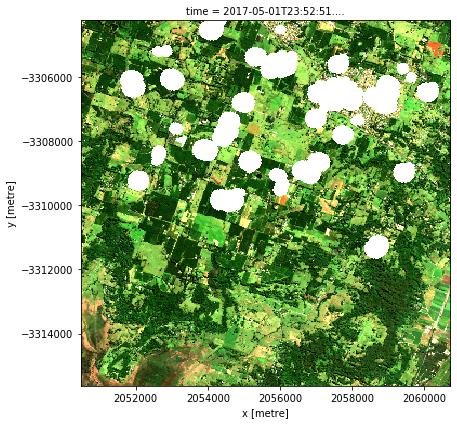

In [31]:
rgb(ds, col='time')


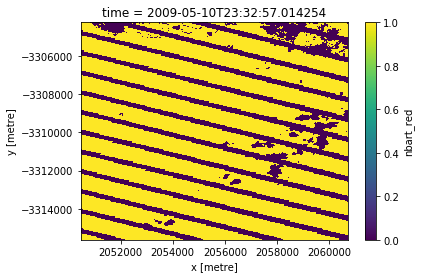

In [14]:
ds.nbart_red.isel(time=45).notnull().plot()

In [ ]:
ds_clean

In [ ]:
bool_mask

In [ ]:
np.logical_or(mask_list)

In [ ]:
    


# The good data percentage calculation has to load in all `fmask`
# data, which can be slow. If the user has chosen no filtering 
# by using the default `min_gooddata = 0`, we can skip this step 
# completely to save processing time
if min_gooddata > 0.0:

    # Compute good data for each observation as % of total pixels
    data_perc = (good_quality.sum(axis=[1, 2], dtype='int32') / 
                 (good_quality.shape[1] * good_quality.shape[2]))

    # Filter by `min_gooddata` to drop low quality observations
    total_obs = len(ds.time)
    ds = ds.sel(time=data_perc >= min_gooddata)
    print(f'Filtering to {len(ds.time)} out of {total_obs} '
          f'observations with at least {min_gooddata:.0%} '
          f'good quality pixels')

# Drop bands not originally requested by user
# ds = ds.drop(to_drop)
print(ds)

In [ ]:
good_contiguity = ds.nbart_contiguity == 1

In [ ]:
np.logical_and()

In [ ]:
import numpy as np

(np.array([False, True, False, False]) *
 np.array([False, True, False, True]))

In [ ]:
dc.find_datasets(product='ga_ls5t_ard_3', **datasets_query)    

In [ ]:
product

In [ ]:
product

In [ ]:
good_quality.sum(dim='time', dtype='int16').compute()

# (good_quality.shape[1] * good_quality.shape[2])

In [ ]:
(ds.nbart_red > 400).sum(dtype='int16')

In [ ]:
(good_quality.sum(axis=1, dtype='int32').sum(axis=1, dtype='int32') / 
(good_quality.shape[1] * good_quality.shape[2]))
 
 
#  .count(axis=1, dtype='int16').sum(axis=1, dtype='int16')).compute()


In [ ]:
good_quality.sum(axis=[1, 2], dtype='int32').compute()

In [ ]:
rgb(ds, index=3)

In [ ]:
                # Compute good data for each observation as % of total pixels
                data_perc = (good_quality.sum(axis=1).sum(axis=1) / 
                    (good_quality.shape[1] * good_quality.shape[2]))

                # Filter by `min_gooddata` to drop low quality observations
                ds = ds.sel(time=data_perc >= min_gooddata)
                print(f'    Filtering to {len(ds.time)} '
                      f'out of {total_obs} observations')

In [ ]:
no_cloud.sum(dim='time')

In [ ]:
# Extract datasets for each product
dataset_list = [dc.find_datasets(product=product, **query) 
                for product in products]
    
# Combine into one list
dataset_list = itertools.chain.from_iterable(dataset_list)

ds = dc.load(datasets=dataset_list, **query)




# Test data load
query = {
#     'x': (153.38, 153.47),
#     'y': (-28.83, -28.92),
#     'time': ('2018-04', '2018-06'),
#     'measurements': ['nbart_green'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

ds = dc.load(datasets=dataset_list, **query)

In [ ]:


post_da = dc.load(product=products[2], **query)





In [ ]:
post_da.isel(time=0)

In [ ]:
f, axarr = plt.subplots(2,3,figsize=(10,8),squeeze=False)
# axarr[0,0].imshow(baseline_NBR,cmap='RdBu',vmin=-1, vmax=1)
# axarr[0,0].set_title('Baseline NBR')
# axarr[0,1].imshow(post_NBR.NBR,cmap='RdBu',vmin=-1, vmax=1)
# axarr[0,1].set_title('Post-fire NBR')
# axarr[0,2].imshow(delta_NBR,cmap='RdBu_r',vmin=-1, vmax=1)
# axarr[0,2].set_title('Delta NBR')
# axarr[1,1].imshow(burnt)
# axarr[1,1].set_title('Burnt area')
# axarr[1,2].imshow(masked,cmap='RdBu_r',vmin=-1, vmax=1)
# axarr[1,2].set_title('Burnt area masked')
rgb(post_da.isel(time=0), bands=['nbart_red', 'nbart_green', 'nbart_blue'], ax=axarr[1,0])

